<a href="https://colab.research.google.com/github/xiaoshaoyc/CSCI-4962/blob/main/CSCI4962_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# we used GPU to accelerate the training
# please make sure the runtime has an available gpu(i.e. 'cuda:0')
# if you want to run it.
!nvidia-smi

Sun Nov  6 16:26:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# init
import math
import time
import copy
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data import TensorDataset
import torch.optim as optim
from torch import nn
from torchsummary import summary

# Part1
I used the CIFAR-10 dataset. The CIFAR-10 dataset contains 60000 images with a resolution of 3x32x32(RGB·W·H) in 10 classes. The dataset is balanced, with 6000 images per class. In addition, this dataset is a clean datatset. As mentioned in previous homework, the EDA we can do for graphic input is limited since every pixel is independent. The CIFAR-10 dataset contains clean data, meaning there is no missing dat. 


In [ ]:
def transform1(x):
  # transformation for raw image data
  return torch.tensor(np.array(x).reshape(-1) / 255)

def y_trans(y):
  # transformation for label
  return (y == 1) * 1.0

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize
     ])

# Here, we store all the data in memory to accelerate training
class Mem_dataset(torch.utils.data.Dataset):
  def __init__(self, dataset) -> None:
    super().__init__()
    self.cache = {}
    self.dataset = dataset

  def __getitem__(self, index):
    if index in self.cache:
      return self.cache[index]
    else:
      item = self.dataset[index]
      self.cache[index] = item
      return item

  def __len__(self):
    return len(self.dataset) 

trainset_raw = torchvision.datasets.CIFAR10(root='./data', train=True,
                     download=True, transform=transform)

testset_raw = torchvision.datasets.CIFAR10(root='./data', train=False,
                     download=True, transform=transform)

# load everything to memory for speed
trainset = Mem_dataset(trainset_raw)
testset = Mem_dataset(testset_raw)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Exploratory Data Analysis
dataset_X, dataset_Y = zip( *(list(trainset) + list(testset)) )
dataset_X = torch.stack(dataset_X)
dataset_Y = torch.tensor(list(dataset_Y))
print('all data')
print(dataset_X.shape)

num_per_class = []
for i in range(10):
  num_per_class.append(
      len(list(filter(lambda x:x==i, dataset_Y)))
  )

print(num_per_class)

print()
print('trainset')
print(f'len(trainset) = {len(trainset)}')

num_per_class = []
for i in range(10):
  num_per_class.append(
      len(list(filter(lambda x:x[1]==i, trainset)))
  )
print(num_per_class)

print()
print('testset')
print(f'len(testset) = {len(testset)}')

num_per_class = []
for i in range(10):
  num_per_class.append(
      len(list(filter(lambda x:x[1]==i, testset)))
  )
print(num_per_class)


"""
There is an excessive amount of data in the testset, 
but 50000 images are enough to train our model.
"""

all data
torch.Size([60000, 3, 32, 32])
[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]

trainset
len(trainset) = 50000
[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]

testset
len(testset) = 10000
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


'\nThere is an excessive amount of data in the testset, \nbut 50000 images are enough to train our model.\n'

torch.Size([3, 32, 32])


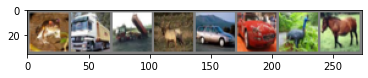

frog  truck truck deer  car   car   bird  horse


In [ ]:
# Exploratory Data Analysis

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #( M, N, 3): an image with RGB values (0-1 float or 0-255 int)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = dataset_X[:8], dataset_Y[:8]
print(images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))



In [ ]:
def draw_loss(loss_list, title):
  plt.plot(loss_list)
  plt.title(title)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  last_x = len(loss_list) - 1
  last_y = loss_list[-1]
  plt.text(last_x*0.95, last_y*1.1, f'{last_y:.4}')


### model architecture

Our model has 5 conv layers and 4 max pooling layers. I added Batch Norm layers
after convolutional layers to reduce covariate shift, and chose `SiLu()` as my activation function to alleviate the vanishing gradient problem. After extracting the feature map to size(1,1), we use a fully connected layer to get the final classcification from our features.

Since our input images are very small, we adopted a small kernel (3x3) to collect as many patterns as possible with reducing training parameters as a side benefit. We utilized max pooling layers to make our feature maps more robust and promote our feature maps to a more abstract level.


In [ ]:
# define model (forward propagation)
def ConvBNSiLUMaxPool(in_ch, out_ch):
  return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, 1, 1),
        nn.BatchNorm2d(out_ch),
        nn.SiLU(),
        nn.MaxPool2d(2, 2), # 16
      )

DEVICE = torch.device('cuda:0')
get_model = lambda : nn.Sequential(
    ConvBNSiLUMaxPool(3, 64), # 16
    ConvBNSiLUMaxPool(64, 128), # 8
    ConvBNSiLUMaxPool(128, 256), # 4
    ConvBNSiLUMaxPool(256, 512), # 2
    nn.Conv2d(512, 1024, 2, stride=2, padding=0), # 1
    nn.SiLU(),
    nn.Flatten(),
    nn.Linear(1024, 10), # 10 classes
    nn.Sigmoid()
)
model = get_model()

In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, e

In [ ]:
summary(model.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              SiLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              SiLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             SiLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

We used `CrossEntropyLoss` as our loss function and accuracy as our metric to evaluate the performance of the model. Accuracy is calculated as 

$$ 
acc = \frac{\text{correct classified images}}{\text{total number of images}}
$$

In [ ]:
# define some useful functions

@torch.no_grad()
def val_acc(m, loss_fn, valloader):
  total_num = 0
  correct_num = 0
  loss_list = []
  m = m.eval()
  for x, y in valloader:
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    y_pred = m(x)
    
    loss = loss_fn(y_pred, y)
    loss_list.append(loss.item())

    y_pred = torch.argmax(y_pred, dim=1)
    correct_num += torch.sum( (y_pred == y)*1 ).item()
    total_num += len(y)

  return correct_num / total_num, sum(loss_list) / len(loss_list)

def train(epoch, m, loss_fn, optimizer, trainloader, valloader=None, best_epoch_start=200):
  pbar = tqdm(range(epoch))
  loss_list = []
  val_acc_list = []
  val_acc_v = 0.
  val_loss = 0.
  best_model = copy.deepcopy(m.state_dict())
  best_val_acc = 0.
  best_epoch = best_epoch_start
  total_time = 0.
  for i in pbar:
    sub_loss_list = []

    m = m.train()
    start = time.time()
    for x, y in trainloader:
      x = x.to(DEVICE)
      y = y.to(DEVICE)
      y_pred = m(x)

      optimizer.zero_grad()
      loss = loss_fn(y_pred, y)
      loss_num = loss.item()
      sub_loss_list.append(loss_num)
      pbar.set_description(f'val_acc={val_acc_v:.4} val_loss={val_loss:.4} loss={loss_num:.4}') 

      loss.backward()
      optimizer.step()

    end = time.time()
    
    total_time = total_time + (end - start)
    epoch_loss = sum(sub_loss_list) / len(sub_loss_list)
    loss_list.append(epoch_loss)

    if valloader is not None:
      del x; del y # free some GPU memory
      val_acc_v, val_loss = val_acc(m, loss_fn, valloader)
      pbar.set_description(f'val_acc={val_acc_v:.4} val_loss={val_loss:.4} loss={loss_num:.4}') 
      val_acc_list.append(val_acc_v)
      if (i > best_epoch) and (val_acc_v > best_val_acc):
        best_epoch = i
        best_val_acc = val_acc_v
        best_model = copy.deepcopy(m.state_dict())

  print(f'\ntraining finished in {total_time}s. Best model at epoch={best_epoch} with val_acc={best_val_acc}')
  m.load_state_dict(best_model)
  return loss_list, val_acc_list

In [ ]:
trainloader = DataLoader(trainset, batch_size=3000, shuffle=True)
testloader = DataLoader(testset, batch_size=3500, shuffle=False)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

#### result
We trained our model for 300 epochs, and the model converged at around epoch 250. The best model is found at epoch 251 with a validation accuracy of 0.7679. We switched to `SGD` as the optimizer to train our model since hyperparameter tuning showed that `SGD` outperforms `Adam`.

In [ ]:
model = get_model().to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()
loss_list, val_acc_list = train(300, model, loss_fn, optimizer, trainloader, testloader)

val_acc=0.7583 val_loss=1.718 loss=1.485: 100%|██████████| 300/300 [49:58<00:00, 10.00s/it]


training finished in 2758.2801716327667s. Best model at epoch=251 with val_acc=0.7679


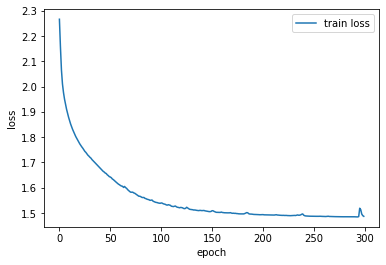

In [ ]:
plt.plot(loss_list, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [ ]:
import time
time_str = time.strftime("%Y-%m-%d-%H:%M")
torch.save(model.state_dict(), f"csci4962_hw5_{time_str}.pt")

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Part 2
We used Resnet18 as our base model and run the transfer learning for 100 epoches. The best model is found at epoch 98 with a validation accuracy of 0.7928. The increased number of parameters of the Resnet18 brings more capacity and more computations, and there are some signs of overfitting even if we set the weight decay to a relatively high value.

However, since the convolutional layers are pretrained, the Resnet18 converged faster than our model. The Resnet18 model also yields a better performance compared to our model since it has more parameters (thus more powerful) and the conv layers are pretrained on ImageNet, a more complex image dataset.

| model | converage at | early stopping at | test accuracy |
|---|---|---|---|
| our model | epoch 250 | epoch 251 | 0.7679 |
| Resnet18 | epoch 15 | epoch 98 | 0.7928 |

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

# https://pytorch.org/vision/main/models.html#initializing-pre-trained-models
# New weights with accuracy 80.858%

# tranfer learning
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(512, 10)
resnet = resnet.to(DEVICE)


In [ ]:
# optimizer2 = optim.Adam(resnet.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.01)
optimizer2 = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
loss_fn2 = nn.CrossEntropyLoss()
loss_list2, val_acc_list2 = train(100, resnet, loss_fn2, optimizer2, trainloader, testloader, 30)


val_acc=0.791 val_loss=0.761 loss=0.01782: 100%|██████████| 100/100 [12:06<00:00,  7.27s/it]


training finished in 6.697664022445679s. Best model at epoch=98 with val_acc=0.7928


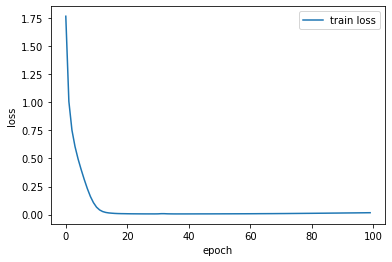

In [ ]:
plt.plot(loss_list2, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [ ]:
time_str = time.strftime("%Y-%m-%d-%H:%M")
torch.save(resnet.state_dict(), f"csci4962_hw5_resnet_{time_str}.pt")

In [ ]:
summary(resnet, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

# Part3
We used two data augmentation techniques: random rotation and random horizontal flip. 

We inially trained our model for 300 epochs, and the model did not converge. So, we trained the model for an additional 300 epochs to a total of 600 epochs, and the model converaged at around epoch 550. The best model is found at epoch 569 with a validation accuracy of 0.8139.

With data augmentation, our model took much longer to converage compared to our model without augmentation since the patterns of images are more complex and hard to predict. The training speed is slowed since our data augmentation is calculated on the CPU, and our low-end two-cores virtual CPU became our bottleneck.

Although we sacrificed the training speed. our accuracy increased obviously. Data augmentation not only guided our model to choose the right patterns (as otherwise loss will increase) for the convolutional layers but also prevented overfitting since we have more unique data samples.


| model | converage at | early stopping at | test accuracy |
|---|---|---|---|
| our model | epoch 250 | epoch 251 | 0.7679 |
| Resnet18 | epoch 15 | epoch 98 | 0.7928 |
| our model with augmentation | epoch 550 | epoch 569 | 0.8139 |

In [ ]:
transform2 = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

trainset_raw2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                     download=True, transform=transform2)

testset_raw2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                     download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 32, 32])


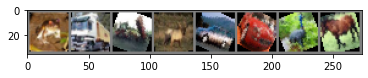

frog  truck truck deer  car   car   bird  horse


In [ ]:
# augmented data
dataset_X, dataset_Y = zip( *(list(trainset_raw2)) )
dataset_X = torch.stack(dataset_X)
dataset_Y = torch.tensor(list(dataset_Y))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #( M, N, 3): an image with RGB values (0-1 float or 0-255 int)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = dataset_X[:8], dataset_Y[:8]
print(images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [ ]:
model2 = get_model().to(DEVICE)

In [ ]:
trainloader = DataLoader(trainset_raw2, batch_size=2500, shuffle=True, num_workers=2)
testloader = DataLoader(testset_raw2, batch_size=3000, shuffle=False, num_workers=2)

# optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

loss_list3, val_acc_list3 = train(300, model2, loss_fn, optimizer, trainloader, testloader)

val_acc=0.7355 val_loss=1.663 loss=1.649: 100%|██████████| 300/300 [1:36:23<00:00, 19.28s/it]


training finished in 5005.21452832222s. Best model at epoch=282 with val_acc=0.7467


In [ ]:
# epoch 301 - epoch 600
loss_list3_2, val_acc_list3_2 = train(300, model2, loss_fn, optimizer, trainloader, testloader, 0)

val_acc=0.7851 val_loss=1.636 loss=1.593: 100%|██████████| 300/300 [1:33:15<00:00, 18.65s/it]


training finished in 4860.53208231926s. Best model at epoch=269 with val_acc=0.8139


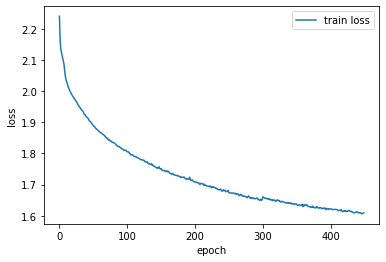

In [ ]:
# showing epoch 0 to epoch 450
plt.plot(loss_list3+loss_list3_2, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [ ]:
time_str = time.strftime("%Y-%m-%d-%H:%M")
torch.save(model.state_dict(), f"csci4962_hw5_aug_{time_str}.pt")